## Анализ событий изменения уровня топлива

In [14]:
# imports
import pandas as pd
from functools import reduce
import numpy as np

#### Константы
- пути к данным
- признаки, описывающие данные
- типы "столбцов", или "подпризнаков"
- ID ТС

In [15]:
DATA_PATH = 'data/vehicle_dataset_public/'
DATA_PROC_PATH = 'data/vehicle_proccessed/'

TAGS_FEATURES = ['fuelLevel', 'ingection', 'speedAndHeight', 'tachometer']
TAGS_TARGET = ['refueling2']
TAGS = TAGS_FEATURES + TAGS_TARGET

TIME_COLUMNS = ['DTIME', 'STARTDATE', 'ENDDATE']
FLOAT_COLUMNS = ['BEVALUE', 'SPEED', 'HEIGHT', 'STARTLEVEL', 'ENDLEVEL']

VEHICLE_IDS = [1, 3, 5, 19, 28]

In [16]:
# Словарь, состоящий из dataframe'ов для каждого признака
def dict_df_vehicle_i(i):
    dict_df_vehicle = {}
    for tag in TAGS:
        df = pd.read_csv(DATA_PATH +
                         f'vehicle{i}_{tag}_public.csv', sep=';')
        for col in FLOAT_COLUMNS:
            if col in df.columns and df[col].dtype == 'object':
                df[col] = df[col].str.replace(',','.').astype(float)
        df.rename(columns={'BEVALUE': tag}, inplace=True)

        for time_col in TIME_COLUMNS:
            if time_col in df.columns:
                df[time_col] = pd.to_datetime(df[time_col])

        dict_df_vehicle[tag] = df

    return dict_df_vehicle

In [17]:
dict_df = dict_df_vehicle_i(1)

In [18]:
def timeDeltaToMinutes(TimeDeltaToMinutes):
    return np.dot(TimeDeltaToMinutes.dt.components, [24*60, 60, 1, 1/60, 1/(60**2), 1/(60**3), 1/(60**4)])

In [19]:
refuelingDF = dict_df['refueling2'].copy()

positiveFuelLevelChange = (refuelingDF['ENDLEVEL'] - refuelingDF['STARTLEVEL']) > 0

refuelingTime = refuelingDF.loc[positiveFuelLevelChange, 'ENDDATE'] - refuelingDF.loc[positiveFuelLevelChange, 'STARTDATE']
print('max refueling duration:', refuelingTime.max())

max refueling duration: 0 days 01:43:32


count                        33
mean     0 days 00:09:24.606060
std      0 days 00:17:41.800532
min             0 days 00:01:00
25%             0 days 00:03:08
50%             0 days 00:05:18
75%             0 days 00:07:54
max             0 days 01:43:32
dtype: object

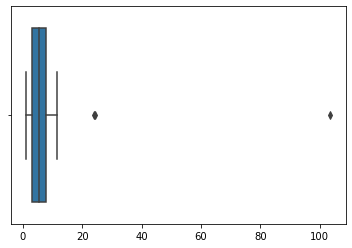

In [20]:
# Время заправки из refueling2

import seaborn as sns

sns.boxplot(timeDeltaToMinutes(refuelingTime))

refuelingTime.describe()

In [21]:
numLongerThen20Minutes = (refuelingTime > pd.to_timedelta('00:20:00')).sum()
print(f'{numLongerThen20Minutes}/{len(refuelingTime)} refuelings took longer than 20 minutes')

3/33 refuelings took longer than 20 minutes


In [22]:
fuelLevelDF = dict_df['fuelLevel'].copy()
fuelLevelDF.head()

,DTIME,fuelLevel
0,2020-01-08 21:16:02,0.0
1,2020-01-08 21:17:04,0.0
2,2020-01-08 21:18:04,0.0
3,2020-01-09 10:05:26,49.7
4,2020-01-09 10:06:27,49.9


In [23]:
fuelLevelDF.loc[1:, 'shifted_DTIME'] = fuelLevelDF['DTIME'].values[:-1]
fuelLevelDF.loc[1:, 'shifted_fuelLevel'] = fuelLevelDF['fuelLevel'].values[:-1]

# времени прошло после пред. измерения
fuelLevelDF['timeShift'] = fuelLevelDF['DTIME'] - fuelLevelDF['shifted_DTIME']
fuelLevelDF['timeShiftMinutes'] = timeDeltaToMinutes(fuelLevelDF['timeShift'])
# изменение уровня топлива
fuelLevelDF['fuelLevelShift'] = fuelLevelDF['fuelLevel'] - fuelLevelDF['shifted_fuelLevel']

del fuelLevelDF['shifted_fuelLevel'], fuelLevelDF['shifted_DTIME']

# в процентах от макс. уровня
vehicleMaxFuelLevel = fuelLevelDF['fuelLevel'].max()
fuelLevelDF['fuelLevelShiftPct'] = fuelLevelDF['fuelLevelShift'] / vehicleMaxFuelLevel

fuelLevelDF.head()

,DTIME,fuelLevel,timeShift,timeShiftMinutes,fuelLevelShift,fuelLevelShiftPct
0,2020-01-08 21:16:02,0.0,NaT,NaN,NaN,NaN
1,2020-01-08 21:17:04,0.0,00:01:02,1.033333,0.0,0.000000
2,2020-01-08 21:18:04,0.0,00:01:00,1.000000,0.0,0.000000
3,2020-01-09 10:05:26,49.7,12:47:22,767.366667,49.7,0.828333
4,2020-01-09 10:06:27,49.9,00:01:01,1.016667,0.2,0.003333


In [24]:
# максимум - 20-ти минутный интервал
# изменение не менее 5%

MAX_TIME_SHIFT_MINUTES = 20
MIN_FUEL_LEVEL_SHIFT_PCT = 0.05

fuelLevelIncreasedSignificantly = (fuelLevelDF['fuelLevelShiftPct'] >= MIN_FUEL_LEVEL_SHIFT_PCT)
notTooLargeTimeShift = (fuelLevelDF['timeShiftMinutes'] <= MAX_TIME_SHIFT_MINUTES)

fuelLevelDF.loc[fuelLevelIncreasedSignificantly & notTooLargeTimeShift]

,DTIME,fuelLevel,timeShift,timeShiftMinutes,fuelLevelShift,fuelLevelShiftPct
30,2020-01-14 09:56:57,49.7,00:01:00,1.000000,49.7,0.828333
72,2020-01-14 10:41:03,51.5,00:02:00,2.000000,51.5,0.858333
128,2020-01-16 11:02:40,46.8,00:01:00,1.000000,46.8,0.780000
268,2020-01-16 13:25:46,56.4,00:04:06,4.100000,56.4,0.940000
494,2020-01-17 15:02:48,50.1,00:01:00,1.000000,50.1,0.835000
...,...,...,...,...,...,...
18375,2020-06-25 16:03:18,32.4,00:07:34,7.566667,32.4,0.540000
18509,2020-06-25 18:46:18,58.8,00:17:33,17.550000,58.8,0.980000
18634,2020-06-26 17:13:03,49.2,00:01:03,1.050000,49.2,0.820000
18740,2020-06-26 19:04:00,59.7,00:01:00,1.000000,59.7,0.995000


In [25]:
# в большинстве случаев бак был изначально пустой

fromNoneZero = fuelLevelDF['fuelLevel'] != fuelLevelDF['fuelLevelShift']

fuelLevelDF.loc[fuelLevelIncreasedSignificantly & notTooLargeTimeShift & fromNoneZero]

,DTIME,fuelLevel,timeShift,timeShiftMinutes,fuelLevelShift,fuelLevelShiftPct
1470,2020-01-22 12:53:35,57.6,00:01:00,1.000000,22.8,0.380000
1818,2020-01-23 12:08:05,55.2,00:03:08,3.133333,29.6,0.493333
2500,2020-01-30 14:45:49,58.8,00:01:00,1.000000,39.7,0.661667
3670,2020-02-13 15:49:21,54.0,00:06:11,6.183333,39.1,0.651667
4397,2020-02-25 15:41:22,46.8,00:01:00,1.000000,26.1,0.435000
5328,2020-03-05 10:18:44,57.4,00:02:00,2.000000,34.4,0.573333
5864,2020-03-13 11:19:12,55.7,00:05:02,5.033333,28.1,0.468333
9190,2020-04-27 16:07:50,52.1,00:08:03,8.050000,30.0,0.500000
9635,2020-04-28 17:28:24,58.8,00:04:52,4.866667,37.2,0.620000
10183,2020-04-29 17:57:59,59.2,00:02:00,2.000000,39.6,0.660000


In [26]:
# но это только для одного ТС!